In [2]:
# read_csv from all files in folder Zero2Heros/data/all year/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


# read csv file
#germ_data = pd.read_csv('/Users/anatolijkekarev/Desktop/jupyter_env/Zeros2Heros/data/all year/gen_DE_B01.csv', sep=',')

In [64]:
# list all the files the folder /Users/anatolijkekarev/Desktop/jupyter_env/Zeros2Heros/data/all year
path = '/Users/anatolijkekarev/Desktop/jupyter_env/Zeros2Heros/data/some year/'
files = os.listdir(path)
files

['load_SE.csv',
 'gen_DE_B19.csv',
 'gen_SE_B16.csv',
 'gen_SE_B13.csv',
 'gen_SE_B12.csv',
 'gen_SE_B19.csv']

Let germany B01 data be an examplar case of datetime statistics!

In [89]:
germ_data = pd.read_csv('/Users/anatolijkekarev/Desktop/jupyter_env/Zeros2Heros/data/all year/gen_DE_B01.csv', sep=',')
germ_data = germ_data.drop(0)

germ_data.rename(columns={'Load':'quantity'}, inplace=True)
germ_data = germ_data[['quantity','StartTime']]
germ_data['quantity'] = germ_data['quantity'].astype(int)
germ_data['StartTime'] = germ_data['StartTime'].apply(lambda s: s.split('+')[0])

germ_data['StartTime'] = germ_data['StartTime'].apply(transform)
germ_data = germ_data.resample('1H', on = 'StartTime').sum()
print(germ_data.isna().sum())

# creating a limbo dataframe to merge all other data into it
limbo = pd.DataFrame(index=germ_data.index)


quantity    0
dtype: int64


In [87]:

def transform(x):
    # Your transformation logic here
    return pd.to_datetime(x)

def clean_data(name):
    # drop columns
    germ_data = pd.read_csv(f'/Users/anatolijkekarev/Desktop/jupyter_env/Zeros2Heros/data/all year/{name}', sep=',')
    print(f'applying the clean_data function to the file: {name}')
    if name.startswith('load'):
        #rename the column 'Load' to 'quantity'
        germ_data.rename(columns={'Load':'quantity'}, inplace=True)

    germ_data = germ_data[['quantity','StartTime']]
    germ_data = germ_data.drop(0)
    # Apply the split operation to the 'StartTime' column
    germ_data['StartTime'] = germ_data['StartTime'].apply(lambda s: s.split('+')[0])
    # Apply the transformation to the 'StartTime' column
    germ_data['StartTime'] = germ_data['StartTime'].apply(transform)

    germ_data['quantity'] = germ_data['quantity'].astype(int)
    # the desired time interval is 1 hour, so we resample the data to 1 hour
    germ_data = germ_data.resample('1H', on = 'StartTime').sum()
    new_name = name.replace('.csv', '').replace('load', 'loa')
    # merge the dataframes on StartTime
    limbo[new_name] = germ_data['quantity']

    #calculate number of non-na values in the column limbo[new_name]
    print(f'data appended to limbo. non-na values : {limbo[new_name].notna().sum()}')



In [90]:
path = '/Users/anatolijkekarev/Desktop/jupyter_env/Zeros2Heros/data/some year/'
files = os.listdir(path)
files

for file in files:
    clean_data(name = file)

applying the clean_data function to the file: load_SE.csv
data appended to limbo. non-na values : 8759
applying the clean_data function to the file: gen_DE_B19.csv
data appended to limbo. non-na values : 8760
applying the clean_data function to the file: gen_SE_B16.csv
data appended to limbo. non-na values : 8759
applying the clean_data function to the file: gen_SE_B13.csv
data appended to limbo. non-na values : 1054
applying the clean_data function to the file: gen_SE_B12.csv
data appended to limbo. non-na values : 8759


In [91]:
# interpolate to guesstimate any missing data
#limbo_interpol = limbo.interpolate(method='linear', limit_direction='both')
#limbo_interpol.isna().sum().max() == 0
# 603.0 got impited for UK data
#limbo_interpol['loa_UK'].tail(3)

# or impute 0 
limbo_interpol = limbo.fillna(0)

In [39]:
# count na and sort them in ascending order
na_list = limbo.isna().sum().sort_values(ascending=False)

In [92]:
coun_dict = {
    'SP': 0,  # Spain
    'UK': 1,  # United Kingdom
    'DE': 2,  # Germany
    'DK': 3,  # Denmark
    'HU': 5,  # Hungary
    'SE': 4,  # Sweden
    'IT': 6,  # Italy
    'PO': 7,  # Poland
    'NL': 8   # Netherlands
}

limbo_slim = pd.DataFrame(index=limbo.index)
for key in coun_dict:
    # create empty column tot_ + key
    limbo_slim[f'tot_{key}'] = 0

for key in coun_dict:
    # for each column in limbo that starts with 'gen'
    for col in [c for c in limbo_interpol.columns if c.startswith('gen')]:
        if key in col:
            limbo_slim[f'tot_{key}'] += limbo_interpol[col]
            

In [83]:
print(365*24*0.2)
limbo.shape

1752.0


(8760, 18)

<Axes: title={'center': 'Green energy loads and production in Sweden'}, xlabel='StartTime'>

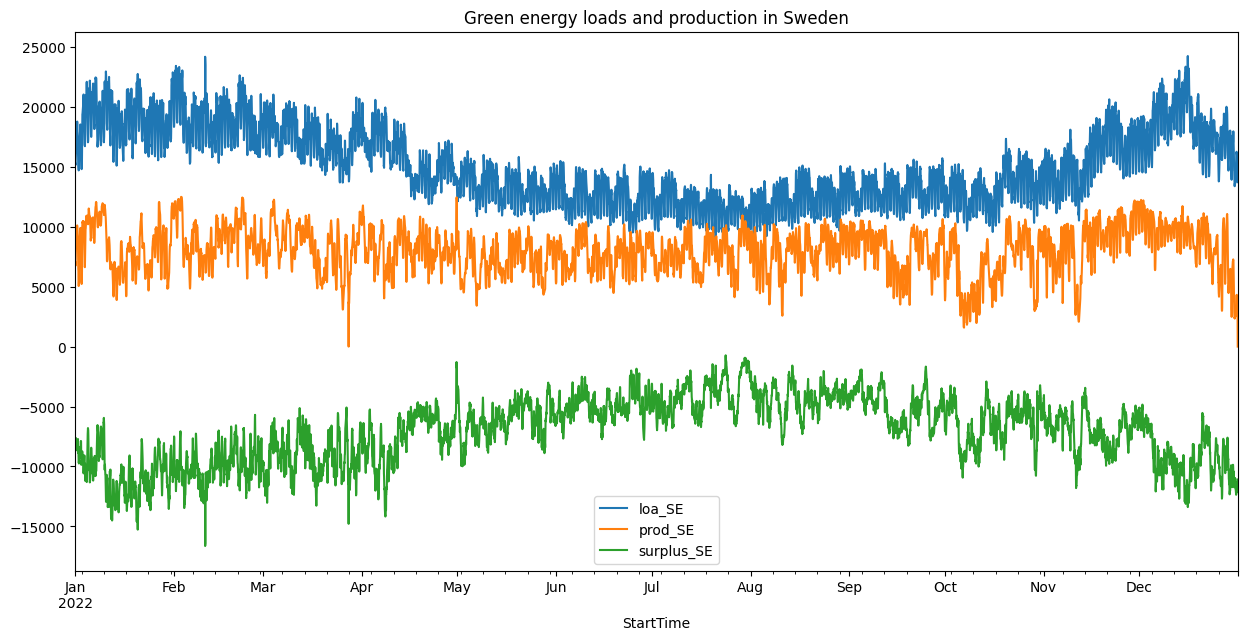

In [95]:
# sum all the columns that start with 'gen'
limbo['prod_SE'] = limbo_slim.tot_SE

# calculate loa_SE minus all other variables sum
limbo['surplus_SE'] = limbo['prod_SE'] - limbo['loa_SE']
#plot all the data
limbo[['loa_SE', 'prod_SE', 'surplus_SE']].plot(subplots=False, figsize=(15,7), title='Green energy loads and production in Sweden') 

In [189]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow import keras
from tensorflow.keras import layers

# split the time series into data and label. save data as X array and label as y number
# the data is loa for 1 month (28*24 hours) and the label is loa for the next hour
coun_dict = {
    'SP': 0,  # Spain
    'UK': 1,  # United Kingdom
    'DE': 2,  # Germany
    'DK': 3,  # Denmark
    'HU': 5,  # Hungary
    'SE': 4,  # Sweden
    'IT': 6,  # Italy
    'PO': 7,  # Poland
    'NL': 8   # Netherlands
}

rawd = pd.read_csv('../data/test.csv')
rawd = rawd.drop(0)

# the length of data context 
datalen = 7*24

# 20 % of the data is used for testing
test_hours = int(len(rawd)*0.2)

#dictionary with X_CO and y_CO where CO is keys of coun_dict

X_y_D = {key: [f'X_{key}', f'y_{key}'] for key in coun_dict.keys()}

for key in coun_dict:
    # for each column in limbo that starts with 'gen'
    for col in [c for c in rawd.columns if c.startswith('green_energy')]:
        if key in col:
            X_y_D[f'prod_{key}'] = rawd[col]
    for col in [c for c in rawd.columns if c.startswith('loa')]:
        if key in col:
            X_y_D[f'load_{key}'] = rawd[col]
            
for key in coun_dict:            
    obs = X_y_D[f'load_{key}']
    obsmax = obs.max()
    obsmin = obs.min()
    obs = (obs- obs.min())/(obs.max() -obs.min())

    obs1 = X_y_D[f'prod_{key}']
    obs1max = obs1.max()
    obs1min = obs1.min()
    obs1 = (obs1- obs1.min())/(obs1.max() -obs1.min())

    # the length of data context 
    
X = []
y = []
for i in range(datalen, len(limbo)):
    X.append(obs[i-datalen:i].tolist())
    y.append(obs[i])
# last test hours of data are used for testing
X_test = X[-test_hours:]    
y_test = y[-test_hours:]
#first = len(X) - test_hours are for traaining
X_train = X[:len(X) - test_hours]
y_train = y[:len(y) - test_hours]


print(print(f'X_train: {len(X_train)} y_train: {len(y_train)} X_test: {len(X_test)} y_test: {len(y_test)}'))

# Assuming X_train is a list of lists
X_train = np.array(X_train)
# Reshape X_train to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

y_train = np.array(y_train)
y_test = np.array(X_test)

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
lrlow = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=lrlow, loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=4, verbose=True)

# Make a prediction
# Reshape X_test to be 3D [samples, timesteps, features]
y_pred = model.predict(X_test)
y_pred = y_pred*(obsmax - obsmin) + obsmin
#save model to access it later
model.save(f'../models/{key}_model_LSTM.h5')
# predict the test data
y_pred = model.predict(X_test)
# plot the results
plt.figure(figsize=(15,7))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()

KeyError: 'load_SP'

In [180]:

X = []
y = []
for i in range(datalen, len(limbo)):
    X.append(model_gym['obs'][i-datalen:i].tolist())
    y.append(model_gym['obs'][i])
    #print(f'X: {X[-1]} y: {y[-1]}')
# last test hours of data are used for testing
X_test = X[-test_hours:]    
y_test = y[-test_hours:]
#first = len(X) - test_hours are for traaining
X_train = X[:len(X) - test_hours]
y_train = y[:len(y) - test_hours]


print(print(f'X_train: {len(X_train)} y_train: {len(y_train)} X_test: {len(X_test)} y_test: {len(y_test)}'))

# the label is NOT in the data! 
X_train[6][-1] == y_train[6]

# Assuming X_train is a list of lists
X_train = np.array(X_train)

# Reshape X_train to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = np.array(X_test)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

y_train = np.array(y_train)

X_train: 6840 y_train: 6840 X_test: 1752 y_test: 1752
None
False


In [181]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow import keras


# Assuming X_train and y_train are your training data
# Reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
lrlow = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=lrlow, loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=4, verbose=True)

# Make a prediction
# Reshape X_test to be 3D [samples, timesteps, features]
y_pred = model.predict(X_test)
y_pred_obs = y_pred
#save model to access it later
#model.save('modeLSTM1.h5')

Epoch 1/4
214/214 [==============================] - 26s 108ms/step - loss: 0.0050
Epoch 2/4
214/214 [==============================] - 27s 124ms/step - loss: 8.6704e-04
Epoch 3/4
214/214 [==============================] - 25s 115ms/step - loss: 6.5184e-04
Epoch 4/4
55/55 [==============================] - 2s 38ms/step


 5/55 [=>............................] - ETA: 1s

55/55 [==============================] - 2s 43ms/step


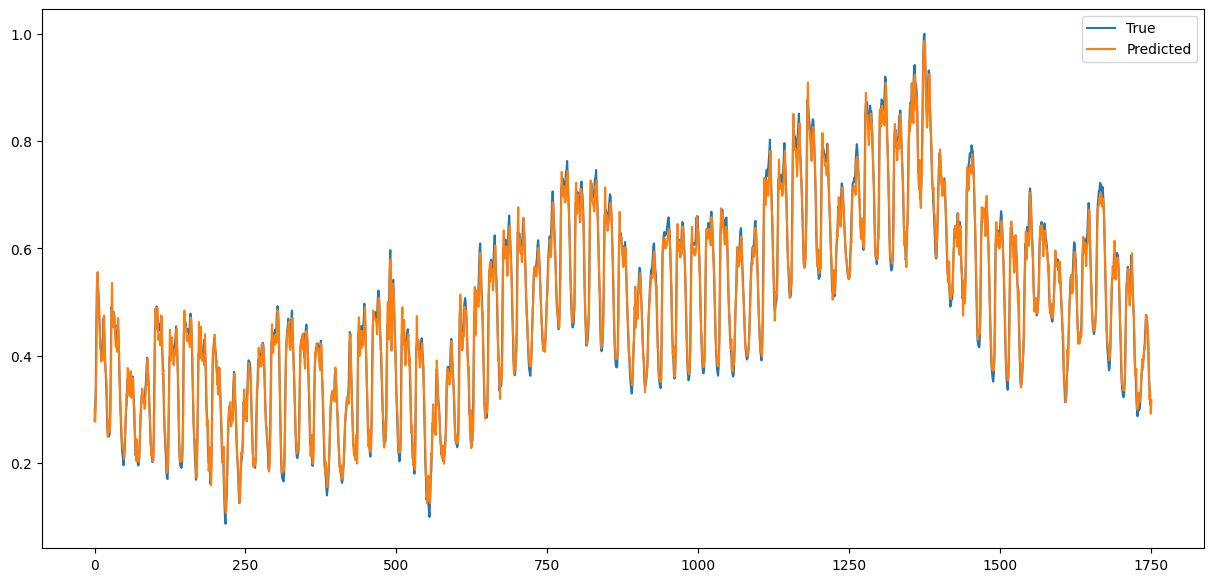

In [172]:
# predict the test data
y_pred = model.predict(X_test)
# plot the results
plt.figure(figsize=(15,7))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()

In [173]:
X = []
y = []
for i in range(datalen, len(limbo)):
    # obs1 is the production data 
    X.append(model_gym['obs1'][i-datalen:i].tolist())
    y.append(model_gym['obs1'][i])
    #print(f'X: {X[-1]} y: {y[-1]}')
# last test hours of data are used for testing
X_test = X[-test_hours:]    
y_test = y[-test_hours:]
#first = len(X) - test_hours are for traaining
X_train = X[:len(X) - test_hours]
y_train = y[:len(y) - test_hours]


print(print(f'X_train: {len(X_train)} y_train: {len(y_train)} X_test: {len(X_test)} y_test: {len(y_test)}'))

# the label is NOT in the data! 
X_train[0][-1] == y_train[0]

# Assuming X_train is a list of lists
X_train = np.array(X_train)

# Reshape X_train to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = np.array(X_test)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

y_train = np.array(y_train)


X_train: 6840 y_train: 6840 X_test: 1752 y_test: 1752
None


In [174]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=7, verbose=True)

# Make a prediction
y_pred = model.predict(X_test)

Epoch 1/7


214/214 [==============================] - 7s 18ms/step - loss: 0.0146
Epoch 2/7
214/214 [==============================] - 4s 17ms/step - loss: 0.0045
Epoch 3/7
214/214 [==============================] - 4s 19ms/step - loss: 0.0031
Epoch 4/7
214/214 [==============================] - 4s 18ms/step - loss: 0.0025
Epoch 5/7
214/214 [==============================] - 4s 17ms/step - loss: 0.0021
Epoch 6/7
214/214 [==============================] - 3s 16ms/step - loss: 0.0018
Epoch 7/7
55/55 [==============================] - 0s 5ms/step


55/55 [==============================] - 0s 6ms/step


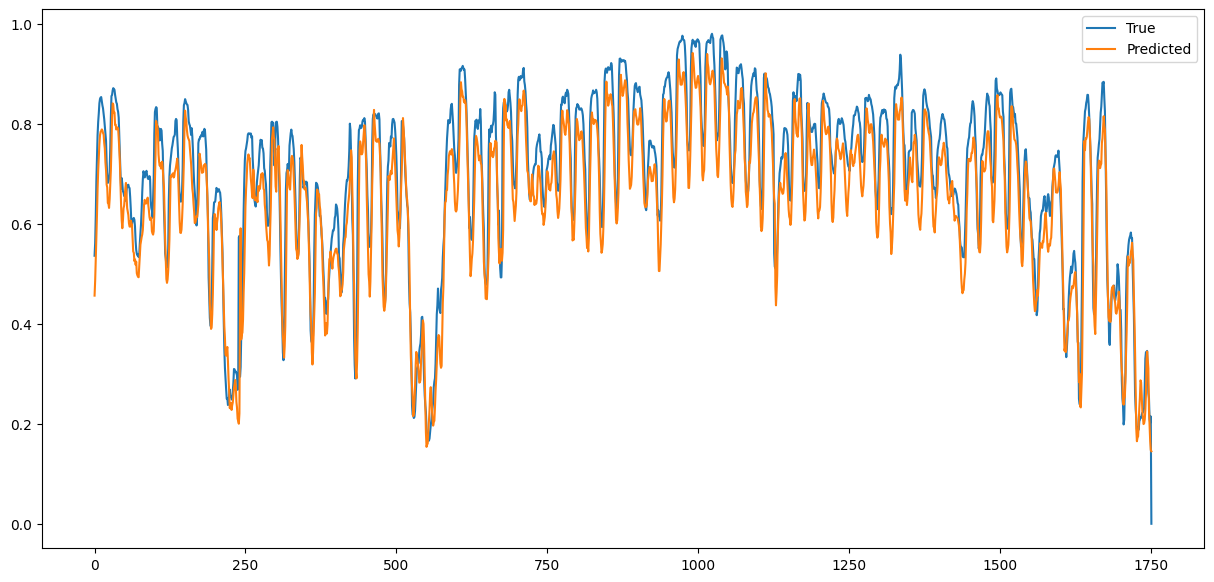

In [176]:
# predict the test data
y_pred = model.predict(X_test)
y_pred_obs1 = y_pred
# plot the results
plt.figure(figsize=(15,7))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()

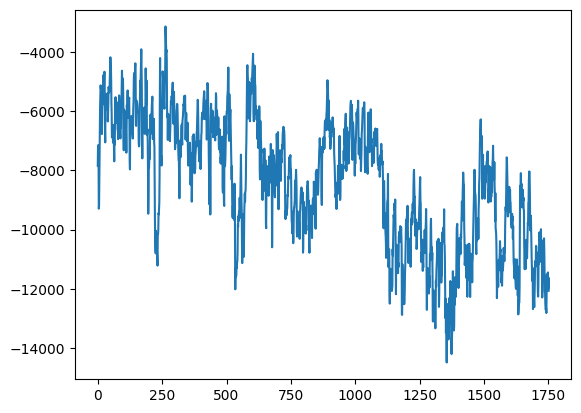

In [184]:
'''
obsmax = model_gym['obs'].max()
obsmin = model_gym['obs'].min()

obs1max = model_gym['obs1'].max()
obs1min = model_gym['obs1'].min()
'''
y_pred_MW = y_pred_obs * (obsmax - obsmin) + obsmin
y_pred_MW1 = y_pred_obs1 * (obs1max - obs1min) + obs1min
predicted_surplus  = y_pred_MW1 - y_pred_MW
plt.plot(predicted_surplus)



UK has observations only till 2022-07-17... 

In [69]:
germ_data = pd.read_csv('/Users/anatolijkekarev/Desktop/jupyter_env/Zeros2Heros/data/all year/load_UK.csv', sep=',')
germ_data = germ_data.drop(0)

germ_data.rename(columns={'Load':'quantity'}, inplace=True)
germ_data = germ_data[['quantity','StartTime']]
germ_data['quantity'] = germ_data['quantity'].astype(int)
germ_data['StartTime'] = germ_data['StartTime'].apply(lambda s: s.split('+')[0])

germ_data['StartTime'] = germ_data['StartTime'].apply(transform)
germ_data.resample('1H', on = 'StartTime').sum()


,quantity
StartTime,
2022-01-01 00:00:00,1244
2022-01-01 01:00:00,1131
2022-01-01 02:00:00,1091
2022-01-01 03:00:00,969
2022-01-01 04:00:00,896
...,...
2022-07-17 19:00:00,786
2022-07-17 20:00:00,759
2022-07-17 21:00:00,1469
